# Result Table Generation

## Imports

In [1]:
import os
import json
import wandb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from evaluation.apply_evaluation import fetch_and_report_wandb

## Settings

In [3]:
# login to wandb
# wandb.login()

In [4]:
%matplotlib inline

## SAE-Train Visualisations

In [16]:
from evaluation.visualise_sae_metrics import load_sae_results, visualize_sae_results_grouped, plot_data_dependence_heatmap

RESULTS_DIRECTORY = "results/saes/"

results_df = load_sae_results(RESULTS_DIRECTORY)
# if not results_df.empty:
    # visualize_sae_results_grouped(results_df)

Found 192 result files. Loading...
Data loaded and processed successfully.


In [17]:
results_df.sort_values(by="mse", ascending=True)

,explained_variance,fraction_var_unexplained,mse,cosine_similarity,activation_sparsity_l0,weight_sparsity,dead_features_pct,dead_features_count,total_latents,eval_dataset,model,layer,sae_train_dataset,sae_token_size,sae_expansion_factor,sae_k_value,sae_checkpoint_name,sae_token_size_mil
72,0.943233,0.056767,1.024234,0.970973,0.003472,0.000029,0.045627,841,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,EQ,50M,32,64,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,50.0
23,0.942723,0.057277,1.033431,0.970637,0.003472,0.000028,0.050130,924,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,INS,50M,32,64,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,50.0
122,0.942610,0.057390,1.035462,0.970636,0.003472,0.000027,0.051866,956,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
124,0.939191,0.060809,1.097150,0.968727,0.003472,0.000028,0.047743,880,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,lmsys,50M,32,64,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,50.0
53,0.942081,0.057919,1.137375,0.968388,0.003472,0.000027,0.067925,1252,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,6,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.953430,0.046570,162.295610,0.840606,0.013889,0.000200,0.139106,641,4608,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,EQ,419M,8,64,smollm2-sparsify-EQ-419M-token-6_25-layers-8-e...,419.0
142,0.952399,0.047601,165.888999,0.821945,0.013889,0.000166,0.126736,584,4608,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,lmsys,419M,8,64,smollm2-sparsify-lmsys-419M-token-6_25-layers-...,419.0
150,0.948181,0.051819,180.588454,0.940902,0.003472,0.000046,0.209852,3868,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,INS,419M,32,64,smollm2-sparsify-INS-419M-token-6_25-layers-32...,419.0
9,0.908226,0.091774,273.553894,0.844701,0.013889,0.000149,0.128689,593,4608,GAIR/lima,HuggingFaceTB/SmolLM2-135M,25,PRE,419M,8,64,smollm2-sparsify-PRE-419M-token-6_25-layers-8-...,419.0


**Pick best SAEs for every layer:**

In [29]:
idx = (
    results_df
    .groupby(["layer", "sae_train_dataset"])["explained_variance"]
    .idxmax()
)
best_df = results_df.loc[idx].reset_index(drop=True)
best_saes_checkpoint_names = best_df["sae_checkpoint_name"].to_list()

In [30]:
best_saes_checkpoint_names

['smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k/layers.25',
 'smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k/layers.25',
 'smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k/layers.25',
 'smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k/layers.25']

In [28]:
best_df

,explained_variance,fraction_var_unexplained,mse,cosine_similarity,activation_sparsity_l0,weight_sparsity,dead_features_pct,dead_features_count,total_latents,eval_dataset,model,layer,sae_train_dataset,sae_token_size,sae_expansion_factor,sae_k_value,sae_checkpoint_name,sae_token_size_mil
0,0.943233,0.056767,1.024234,0.970973,0.003472,0.000029,0.045627,841,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,EQ,50M,32,64,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,50.0
1,0.942723,0.057277,1.033431,0.970637,0.003472,0.000028,0.050130,924,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,INS,50M,32,64,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,50.0
2,0.942610,0.057390,1.035462,0.970636,0.003472,0.000027,0.051866,956,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
3,0.939191,0.060809,1.097150,0.968727,0.003472,0.000028,0.047743,880,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,lmsys,50M,32,64,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,50.0
4,0.987426,0.012574,43.821970,0.964894,0.003472,0.000026,0.176704,3257,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,EQ,50M,32,64,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,50.0
5,0.988271,0.011729,40.874484,0.964429,0.003472,0.000024,0.180881,3334,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,INS,50M,32,64,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,50.0
6,0.989657,0.010343,36.044102,0.964745,0.003472,0.000026,0.182237,3359,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
7,0.987441,0.012559,43.769764,0.961539,0.003472,0.000025,0.165527,3051,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,lmsys,50M,32,64,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,50.0


In [7]:
results_df.to_csv("results/saes/aggregations/saes.csv", index=False)

In [8]:
df_summary = results_df.groupby(["sae_train_dataset", "sae_expansion_factor", "eval_dataset"]).agg({
    "explained_variance": "mean",
    "dead_features_pct": "mean",
    "activation_sparsity_l0": "mean"
}).reset_index()

--- Generating plot for explained_variance ---
Plot saved to results/visualizations/avg_explained_variance_across_ds.png


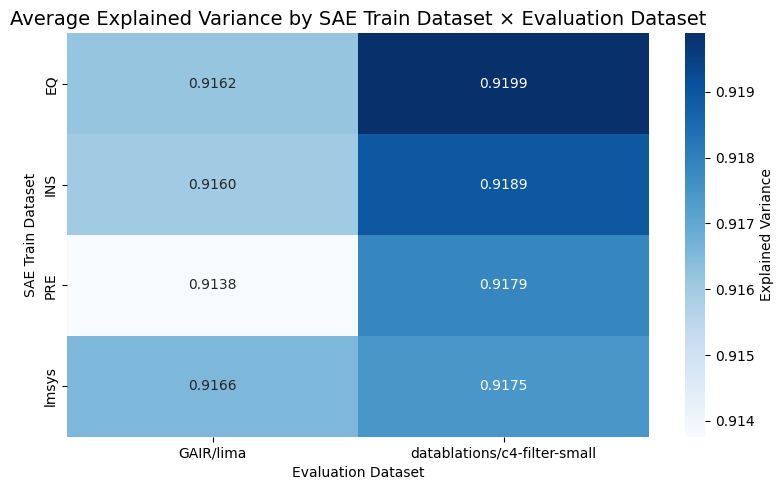

--- Generating plot for mse ---
Plot saved to results/visualizations/avg_mse_across_ds.png


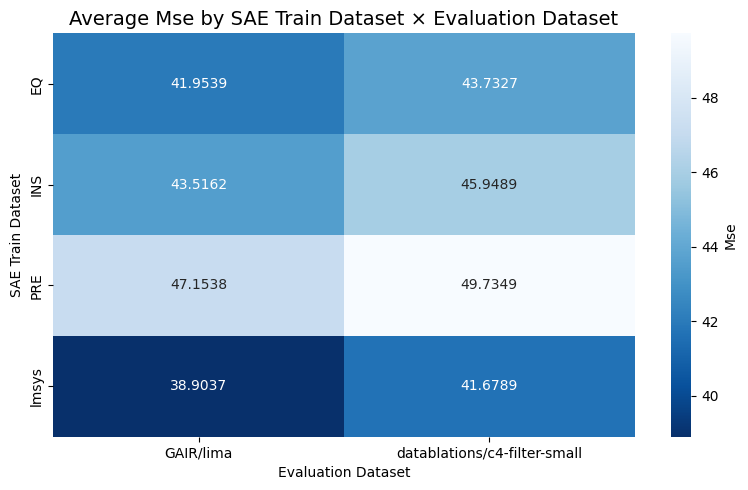

--- Generating plot for cosine_similarity ---
Plot saved to results/visualizations/avg_cosine_similarity_across_ds.png


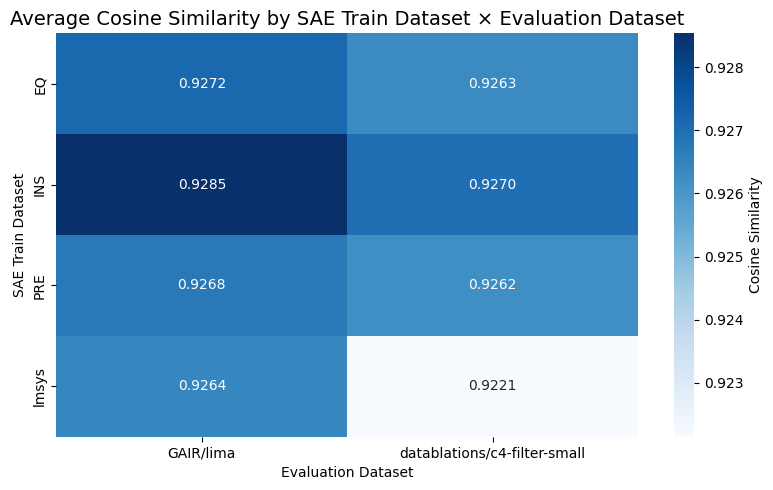

In [9]:
metric_list = [
    "explained_variance",
    # "fraction_var_unexplained",
    "mse",
    "cosine_similarity",
    # "activation_sparsity_l0",
    # "weight_sparsity",
    # "dead_features_pct"
]

for metric in metric_list:
    print(f"--- Generating plot for {metric} ---")
    
    # Use a different colormap for metrics where "higher is worse" (like MSE)
    color_map = "Blues_r" if metric in ["mse", "fraction_var_unexplained"] else "Blues"
    
    # Use a different format for percentages
    num_format = ".2f" if "pct" in metric else ".4f"

    plot_data_dependence_heatmap(
        df=results_df,
        metric_name=metric,
        # results_path=results_path,
        cmap=color_map,
        fmt=num_format
    )

## Dataset-visuals

/tmp/ipykernel_602330/1866428773.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
/tmp/ipykernel_602330/1866428773.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
/tmp/ipykernel_602330/1866428773.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
/tmp/ipykernel_602330/1866428773.py:29: FutureWarning: 

Passing `palette` without as

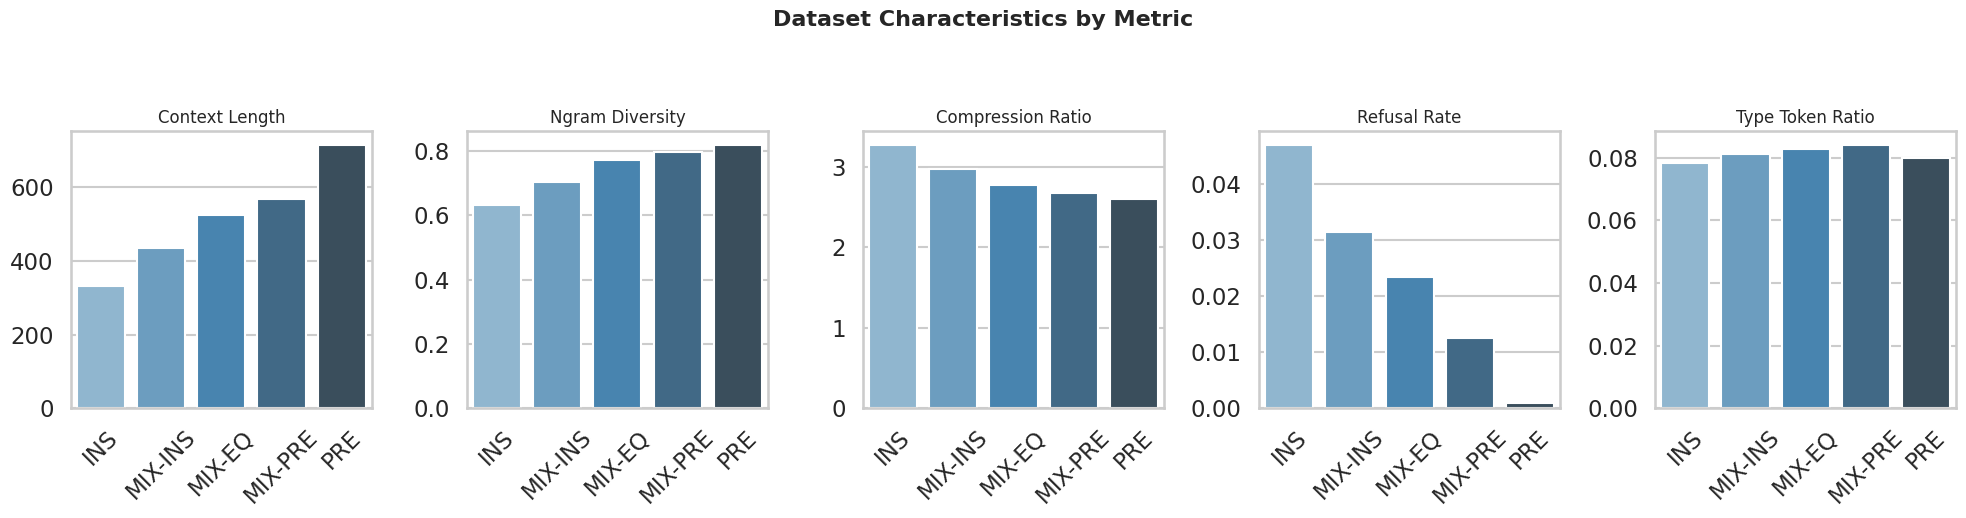

In [15]:
sns.set_theme(style="whitegrid", context="talk")

results_dir = "results/dataset_chars"
data = []
for fname in os.listdir(results_dir):
    if fname.endswith("_metrics.json"):
        with open(os.path.join(results_dir, fname), "r") as f:
            d = json.load(f)
        d["dataset"] = fname.replace("_metrics.json", "")
        data.append(d)

df = pd.DataFrame(data)
df.set_index("dataset", inplace=True)

ordered_datasets = ["INS", "MIX-INS", "MIX-EQ", "MIX-PRE", "PRE"]

# Filter and reorder the dataframe accordingly
df_filtered = df.loc[df.index.intersection(ordered_datasets)]
df_ordered = df_filtered.reindex(ordered_datasets)

# Plot each metric separately using the ordered dataset list
metrics = ["context_length", "ngram_diversity", "compression_ratio", "refusal_rate", "type_token_ratio"]
n_metrics = len(metrics)

fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(4 * n_metrics, 5), sharex=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
    ax.set_title(metric.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("")  # suppress for compactness
    ax.set_xlabel("")

    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.suptitle("Dataset Characteristics by Metric", fontsize=16, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig("./results/visualizations/dataset_chars.png", dpi=150, bbox_inches='tight')
plt.show()

## Report Gathering & Tables

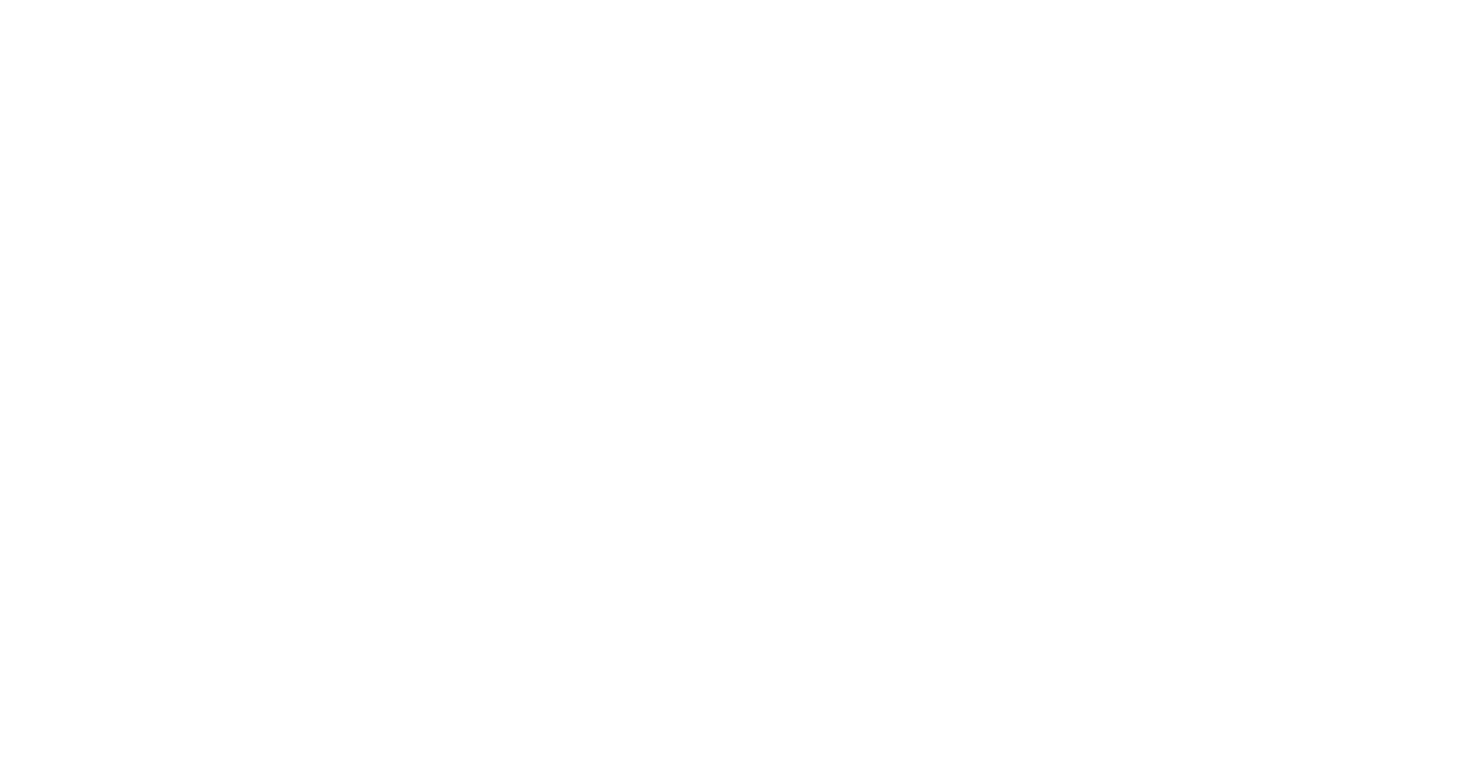

In [11]:
df_long, df_short, latex_long, latex_short, fig = fetch_and_report_wandb(
    "tilmankerl-technical-university-of-vienna/MA-sae-train/k867a0u3"
)

In [12]:
display(df_long)
display(df_short)

,Metric,Value
0,Explained Variance,-21.291372
1,Reconstruction MSE,112.596863
2,Cosine Similarity,0.905586
3,Overall Loss,487019.312500
4,MSE Loss,484256.343750
5,L1 Loss,5525.955078
6,Activation Sparsity (L0),4069.241943
7,L1 Sparsity (sum abs activ.),5526.010254
8,Dead Features,0.000000
9,Shrinkage (L2 Ratio),6.015663


,Metric,Value
0,Explained Variance,-21.291372
1,Reconstruction MSE,112.596863
2,Activation Sparsity (L0),4069.241943
3,L1 Sparsity,5526.010254
4,Overall Loss,487019.312500
5,CE Loss (no SAE),2.719747


In [13]:
print(latex_long)
print(latex_short)

\begin{table}
\caption{SAE Training results for \texttt{pythia-410m-deduped} on hook \texttt{blocks.10.hook_resid_post}, using the \texttt{lmsys-chat-1m-english-tokenized} dataset.}
\label{tab:sae_metrics_full}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Explained Variance & -21.2914 \\
Reconstruction MSE & 112.5969 \\
Cosine Similarity & 0.9056 \\
Overall Loss & 487019.3125 \\
MSE Loss & 484256.3438 \\
L1 Loss & 5525.9551 \\
Activation Sparsity (L0) & 4069.2419 \\
L1 Sparsity (sum abs activ.) & 5526.0103 \\
Dead Features & 0.0000 \\
Shrinkage (L2 Ratio) & 6.0157 \\
Relative Recon. Bias & 6.5952 \\
CE Loss (no SAE) & 2.7197 \\
CE Loss (with SAE) & 4.4576 \\
CE Loss (ablation) & 11.6825 \\
CE Loss Score & 0.8061 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{SAE Training results for \texttt{pythia-410m-deduped} on hook \texttt{blocks.10.hook_resid_post}, using the \texttt{lmsys-chat-1m-english-tokenized} dataset.}
\label{tab:sae_metrics_short}
\begin{tabula